<a href="https://colab.research.google.com/github/andipasti/smupo/blob/main/Classic_LLM_openai_24_04_24-II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MASTER THESIS

## INITIALIZATION

In [ ]:
#SETTING GLOBALS

DF_SMALL = './drive/Othercomputers/X1/code/datas_small.json'
DF_MID = './drive/Othercomputers/X1/code/datas_mid.json'
DF_LARGE = './drive/Othercomputers/X1/code/datas_large.json'

DF_SMALL_SUM = './drive/Othercomputers/X1/code/processed_summarization_per_ticket_small.json'
DF_MID_SUM = './drive/Othercomputers/X1/code/processed_summarization_per_ticket_mid.json'
DF_LARGE_SUM = './drive/Othercomputers/X1/code/processed_summarization_per_ticket_large.json'

EMBEDDINGS_SMALL = './drive/Othercomputers/X1/code/embeddings/embeddings-small-initial.npy'
EMBEDDINGS_MID = './drive/Othercomputers/X1/code/embeddings/embeddings-mid-initial.npy'
EMBEDDINGS_LARGE = './drive/Othercomputers/X1/code/embeddings/embeddings-large-initial.npy'

EMBEDDINGS_SMALL_UPDATED = './drive/Othercomputers/X1/code/embeddings/embeddings-updated-mid.npy'
EMBEDDINGS_MID_UPDATED = './drive/Othercomputers/X1/code/embeddings/embeddings-updated-mid.npy'
EMBEDDINGS_LARGE_UPDATED = './drive/Othercomputers/X1/code/embeddings/embeddings-updated-mid.npy'

MAX_DISTANCE = 3.5;




In [ ]:
# INSTALL NEEDED LIBRARIES
!pip install openai==0.28
!pip install umap-learn
!pip install wordcloud

In [ ]:
# CREATE ACCESS TO SECRETS
import os

# Now you can proceed with your code that requires this environment variable
from google.colab import userdata
os.environ['HUGGINGFACE_TOKEN'] = userdata.get('HUGGINGFACE_TOKEN')

In [ ]:
import openai
import pandas as pd

from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
print("DONE")

In [ ]:
# CHECKING
import os

# Check if the OPENAI_API_KEY environment variable is set
if "OPENAI_API_KEY" in os.environ:
    print("OpenAI API key is set.")
else:
    print("OpenAI API key is not set.")



In [ ]:
# CONNECT TO DRIVE
from google.colab import drive
drive.mount('/content/drive')



---



### GETTING DATAS AND PREPROCESSING

In [ ]:
import pandas as pd
# Loading the dataset from a JSON file
df = pd.read_json(DF_MID)
display(df)

In [ ]:
column_names = list(df.columns)
print(column_names)

In [ ]:
df.drop(['journal_id', 'journal_created_on', 'journal_author', 'journal_notes', 'issue_id'], axis=1, inplace=True)


In [ ]:
column_names = list(df.columns)
print(column_names)


In [ ]:
# Set Pandas display options to show the full content of 'merged_journal_notes'
pd.set_option('display.max_colwidth', None)
df.head()

In [ ]:
import pandas as pd

# Example DataFrame
# df = pd.DataFrame({'text': ["Example text\r\n\r\nwith special characters &*%$#@!"]})

# Replace "\r\n\r\n" with a space
df['issue_description'] = df['issue_description'].str.replace(r"\n", " ", regex=True)
df['issue_description'] = df['issue_description'].str.replace(r"\r", " ", regex=True)

# Replace any character that is not a letter, number, or common punctuation with a space
df['issue_description'] = df['issue_description'].str.replace(r"[^a-zA-Z0-9\s.,;!?']", " ", regex=True)

df['issue_description'] = df['issue_description'].str.lower()

df.head()


In [ ]:
df['combined_text'] = "Title: " + df['issue_title'] + ". Description: " + df['issue_description']
df['combined_text'] = df['combined_text'].str.lower()

In [ ]:
len(df)

In [ ]:
df.head(2)

### RESTRUCTURE TICKET INFORMATION WITH HELP OF LLM

In [ ]:
import os
import pandas as pd
import openai


def rework_ticket_description_with_gptturbo(ticket_text):
    """
    Reworks a ticket description into a structured summary using the GPT-3.5 Turbo model through Chat Completion.

    :param ticket_text: The text of the ticket.
    :return: Reworked ticket text.
    """

    # Explicitly set the OpenAI API key
    openai.api_key = os.getenv("OPENAI_API_KEY")

    detailed_instructions = (
        "You are a highly capable technical supporter. For each issue, provide a summary categorized under the following headers:\n"
        "- Issue: [Specify the type of issue e.g., Support, IT-Systems, Development]\n"
        "- Afftected Systems: [List affected systems e.g., VDI, Email Servers, etc.]\n"
        "- Reported Problem: [Describe the reported problem e.g., no connection, slow performance, etc.]"
    )

    try:
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": detailed_instructions},
                {"role": "user", "content": ticket_text}
            ]

        )

        # Assuming the response structure has a 'choices' list with at least one item,
        # and 'message' contains the 'content' field with our reworked text.
        if response and 'choices' in response and len(response['choices']) > 0:
            reworked_text = response['choices'][0].get('message', {}).get('content', '')
            return reworked_text.strip()
        else:
            return "Failed to generate reworked text. No valid response."
    except Exception as e:
        return f"An error occurred: {str(e)}"


In [ ]:
df

In [ ]:
#################################################################################################
# SHORTCUT: IF FILE ALREADY EXISTS: TAKE IT, OTHERWISE DO THE REWORK
#################################################################################################

from google.colab import files

# Check if the specific file exists
file_path = DF_MID_SUM  # Specify the correct file path
if not os.path.exists(file_path):
    # If the file does not exist, apply the function to the DataFrame
    df['reworked_information'] = df['combined_text'].apply(rework_ticket_description_with_gptturbo)
    df.to_json(DF_MID_SUM, orient='records', lines=True)
    files.download(DF_MID_SUM)

    print("Function applied because the file does not exist.")
else:
  # Read the JSON file into a DataFrame
    print("File exists. Summarization for each ticket is not applied. File is loaded from Filesystem")
    df = pd.read_json(DF_MID_SUM, lines=True)


# Display the first few rows of the processed DataFrame
df.head()

## CREATE EMBEDDING

In [ ]:
# CLEAN DATAS
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
import re

# Download necessary resources
nltk.download('punkt')  # Tokenizers
nltk.download('stopwords')  # Stopwords list for English and German

# Set up stopwords for both German and English
stop_words = set(stopwords.words('english')).union(set(stopwords.words('german')))

def clean_text(text):
    # Check if the text is a string
    if not isinstance(text, str):
        return ""  # Return empty string if text is not a string

    # Convert to lowercase
    text = text.lower()

    # Remove specific unwanted words
    specific_unwanted_words = ['reported problem', 'ticket', 'summary', 'affected systems', 'reported problem', 'issue']
    pattern = r'\b(?:' + '|'.join(specific_unwanted_words) + r')\b'
    text = re.sub(pattern, '', text)

    # Tokeniation and stopwords removal
    words = nltk.word_tokenize(text)
    words = [word for word in words if word not in stop_words and word.isalpha()]

    return ' '.join(words)

# Assuming df is your DataFrame and 'reworked_information' is the column with texts
df['cleaned_information'] = df['reworked_information'].apply(clean_text)

In [ ]:
# USE OPENAI MODEL TO CREATE EMBEDDINGS OUT OF REWORKED INFORMATION

from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import pandas as pd
import openai
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Function to get embeddings from OpenAI
def get_openai_embeddings(texts, embeddings_file_path):

  # Explicitly set the OpenAI API key
  openai.api_key = os.getenv("OPENAI_API_KEY")

  if not os.path.exists(embeddings_file_path):
    embeddings = []
    for text in texts:
        response = openai.Embedding.create(
            input=text,
            engine="text-embedding-3-large"
        )
        embeddings.append(response['data'][0]['embedding'])

    # save:
    np.save(embeddings_file_path, embeddings)
  else:
    embeddings = np.load(embeddings_file_path)
    print("EMBEDDING read: ", embeddings.shape[0])

  return np.array(embeddings)



In [ ]:
# EXECUTING IT
texts = df['cleaned_information'].tolist()
embeddings_file_path = EMBEDDINGS_MID
matrix = get_openai_embeddings(texts, embeddings_file_path)
embeddings = matrix
print(matrix.shape[0])

In [ ]:
df

TODO:  
- different models
- optimize preprocessing (normalize, stopwords, lemmatization,...)
- fine-tuning embeddings /hybrid approach (using z.b randomForest after clustering)
- dimensionality reduction (PCA f.e.)


## CREATE CLUSTERS V1

### WARD

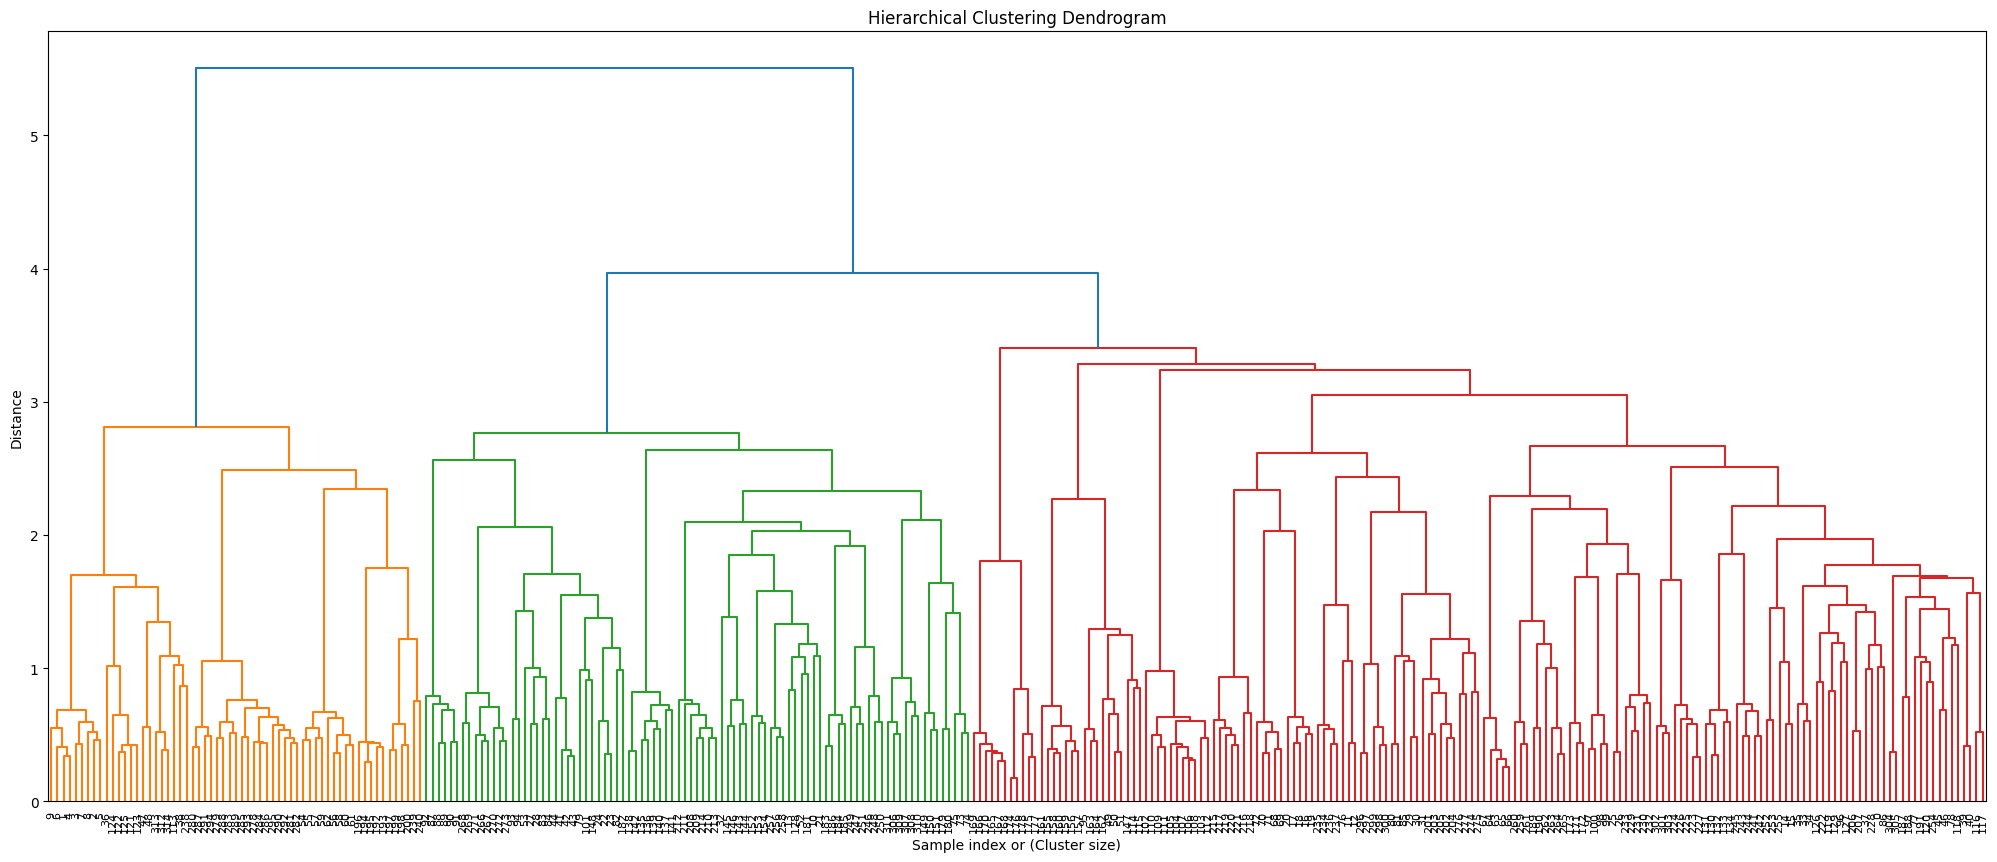

In [44]:
# Perform hierarchical clustering

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

Z = linkage(matrix, 'ward')

# Plot the dendrogram to visualize clusters
plt.figure(figsize=(25, 10))
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index or (Cluster size)')
plt.ylabel('Distance')
plt.show()

### DBSCAN

In [51]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def perform_dbscan_clustering(matrix):
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    clusters = dbscan.fit_predict(matrix)
    return clusters

# Ensure matrix used for DBSCAN and DataFrame have consistent sizes
if len(matrix) == len(df):
    clusters = perform_dbscan_clustering(matrix)
    print(clusters)
    df['cluster_label'] = clusters  # Safely assign clusters because lengths match
else:
    print(f"Error: Matrix length {len(matrix)} does not match DataFrame length {len(df)}.")

# Optional: Plot clusters if you wish to visualize
# plot_clusters_with_umap(matrix, clusters)


def plot_clusters(matrix, clusters):
    # Perform dimensionality reduction for visualization if it's not 2D
    tsne = TSNE(n_components=2, random_state=42)
    matrix_2d = tsne.fit_transform(matrix)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(matrix_2d[:, 0], matrix_2d[:, 1], c=clusters, cmap='viridis')
    plt.colorbar(scatter)
    plt.title('DBSCAN Clustering Visualization')
    plt.xlabel('TSNE Dimension 1')
    plt.ylabel('TSNE Dimension 2')
    plt.show()


import matplotlib.pyplot as plt
import umap.umap_ as umap

def plot_clusters_with_umap(matrix, clusters):
    # Use UMAP for dimensionality reduction
    reducer = umap.UMAP(random_state=42)
    matrix_2d = reducer.fit_transform(matrix)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(matrix_2d[:, 0], matrix_2d[:, 1], c=clusters, cmap='viridis')
    plt.colorbar(scatter)
    plt.title('DBSCAN Clustering Visualization with UMAP')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.show()





[-1  0  0 -1  0  0  0  0  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1  1 -1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1  2  2  2  2  2  2  2  2  2  2 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  3  3  3  3  3  3 -1 -1 -1 -1  4  4  4
  4  4  4 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  5  5  5  5  5 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  6 -1 -1  6  6 -1  6 -1  6 -1
 -1  6  6 -1  6 -1 -1  6 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1]


In [62]:
from sklearn.cluster import KMeans

# Assuming 'matrix' is your embeddings matrix obtained from get_openai_embeddings function
def perform_kmeans_clustering(matrix, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
    clusters = kmeans.fit_predict(matrix)
    return clusters

# Example usage
num_clusters = 3  # Based on your elbow method result
kmeans_clusters = perform_kmeans_clustering(matrix, num_clusters)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [63]:
from sklearn.cluster import SpectralClustering

def perform_spectral_clustering(matrix, n_clusters):
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors',
                                  assign_labels='kmeans', random_state=42)
    clusters = spectral.fit_predict(matrix)
    return clusters

n_clusters = 3
spectral_clusters = perform_spectral_clustering(matrix, n_clusters)


### CHECK HOW MANY CLUSTERS WOULD BE USEFUL (KMEANS)

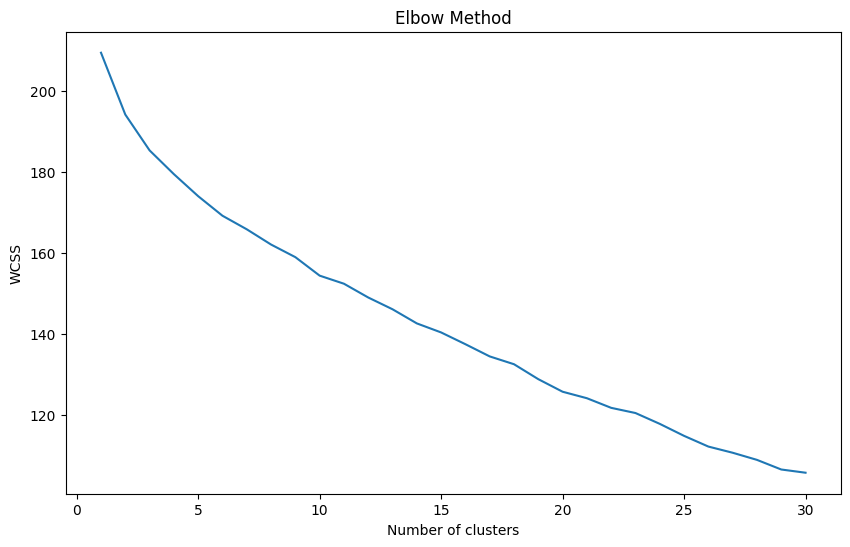

In [53]:

# Check with kmeans to be sure about amount of clusters
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming 'matrix' is the embeddings matrix obtained from get_openai_embeddings function
wcss = []
for i in range(1, 31):  # Test for k values from 1 to 10, adjust the range as necessary
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=15, random_state=0)
    kmeans.fit(matrix)
    wcss.append(kmeans.inertia_)  # Inertia: Sum of distances of samples to their closest cluster center

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 31), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # Within-cluster sum of squares
plt.show()


In [49]:
df


,issue_title,issue_description,combined_text,reworked_information,cleaned_information,cluster_label
0,[MBA#1127156] Layout-Anpassung auf Typo 3 - Webseite (KWI),"guten morgen ich habe eine eher spezielle anfrage von der kantonsschule wiedikon. die kantonsschule wiedikon w nscht eine layout anpassung f r mobile ger te zu machen f r das video welches auf der webseite der kwi baustand der hohlstrasse hochgeladen wurde. die kontaktperson bei fr heren anpassungen bei euch war noemi schmid. die schule w nscht nun eine kontaktaufnahme von euch mit herrn philippe da silva wong, tel. 044 457 71 53 um die einzelheiten zu besprechen. w re eine kontaktaufnahme seitens von euch m glich? dieses ticket eilt ein wenig da es schon l nger auf eine antwort wartet. ich habe das ticket am 27.02.2024 an euch weitergeleitet ohne r ckmeldung bis jetzt. freundliche gr sse kushtrim veliji bildungsdirektion kanton z rich mittelschul und berufsbildungsamt digital service center sek ii ausstellungsstrasse 80 8090 z rich telefon 043 259 77 27","title: [mba#1127156] layout-anpassung auf typo 3 - webseite (kwi). description: guten morgen ich habe eine eher spezielle anfrage von der kantonsschule wiedikon. die kantonsschule wiedikon w nscht eine layout anpassung f r mobile ger te zu machen f r das video welches auf der webseite der kwi baustand der hohlstrasse hochgeladen wurde. die kontaktperson bei fr heren anpassungen bei euch war noemi schmid. die schule w nscht nun eine kontaktaufnahme von euch mit herrn philippe da silva wong, tel. 044 457 71 53 um die einzelheiten zu besprechen. w re eine kontaktaufnahme seitens von euch m glich? dieses ticket eilt ein wenig da es schon l nger auf eine antwort wartet. ich habe das ticket am 27.02.2024 an euch weitergeleitet ohne r ckmeldung bis jetzt. freundliche gr sse kushtrim veliji bildungsdirektion kanton z rich mittelschul und berufsbildungsamt digital service center sek ii ausstellungsstrasse 80 8090 z rich telefon 043 259 77 27","- **Issue:** Development\n- **Affected Systems:** Website (Typo3)\n- **Reported Problem:** The Kantonsschule Wiedikon requests a layout adjustment for mobile devices for a video uploaded on the website. The contact person for previous adjustments was Noemi Schmid. They now seek contact with Mr. Philippe Da Silva Wong at 044 457 71 53 to discuss the details. The request is time-sensitive, as it has been pending a response since 27.02.2024. Please reach out to them for further details.",development website kantonsschule wiedikon requests layout adjustment mobile devices video uploaded website contact person previous adjustments noemi schmid seek contact philippe silva wong discuss details request pending response since please reach details,3.0
1,[MBA#1128940] Zimbra Störung komplette Schule: E-Mails senden und empfangen (kslzh.ch) funktioniert nicht,"guten morgen allerseits schule kslzh melder laszlo cseri problem zimbra wir kslzh.ch k nnen keine e mails senden auch mails von gmx und icloud.com versendet und empfangen. im webmail erhalten wir folgende hinweise beim versenden von e mails !clipboard 202403250751 h8l4i.png! !clipboard 202403250751 h6e8a.png! eine berpr fung mit mxtoolbox zeigt bei einem smtp check folgendes an !clipboard 202403250751 2pdnb.png! d rfen wir euch bitten, das problem sofort zu beheben? nachtrag bei meinen recherchen habe ich festgestellt, dass es auch die stud.kslzh.ch domain auch betrifft !clipboard 202403250752 fxdsc.png!","title: [mba#1128940] zimbra störung komplette schule: e-mails senden und empfangen (kslzh.ch) funktioniert nicht. description: guten morgen allerseits schule kslzh melder laszlo cseri problem zimbra wir kslzh.ch k nnen keine e mails senden auch mails von gmx und icloud.com versendet und empfangen. im webmail erhalten wir folgende hinweise beim versenden von e mails !clipboard 202403250751 h8l4i.png! !clipboard 202403250751 h6e8a.png! eine berpr fung mit mxtoolbox zeigt bei einem smtp check folgendes an !clipboard 202403250751 2pdnb.png! d 

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import linkage, fcluster
import umap

def perform_hierarchical_clustering(embeddings, MAX_DISTANCE):
    Z = linkage(embeddings, 'ward')
    clusters = fcluster(Z, MAX_DISTANCE, criterion='distance')
    print("Number of clusters formed:", len(np.unique(clusters)))
    return clusters, Z

def visualize_umap(embeddings, clusters):
    umap_reducer = umap.UMAP()
    umap_result = umap_reducer.fit_transform(embeddings)
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], c=clusters, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter)
    plt.title('UMAP Visualization of Clusters')
    plt.xlabel('UMAP Feature 1')
    plt.ylabel('UMAP Feature 2')
    plt.show()




In [ ]:
# EXCECUTE IT
# Perform clustering
clusters, Z = perform_hierarchical_clustering(embeddings, MAX_DISTANCE)
df['cluster_label'] = clusters  # Assign cluster labels to DataFrame

# Visualize using UMAP
visualize_umap(embeddings, clusters)

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
import re

# Download stopwords and wordnet for NLTK
nltk.download('stopwords')
nltk.download('wordnet')

# Set up stopwords for both German and English
stop_words = set(stopwords.words('english')).union(set(stopwords.words('german')))


In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
import re

# Download necessary resources
nltk.download('punkt')  # Tokenizers
nltk.download('stopwords')  # Stopwords list for English and German

# Set up stopwords for both German and English
stop_words = set(stopwords.words('english')).union(set(stopwords.words('german')))

def clean_text(text):
    # Check if the text is a string
    if not isinstance(text, str):
        return ""  # Return empty string if text is not a string

    # Convert to lowercase
    text = text.lower()

    # Remove specific unwanted words
    specific_unwanted_words = ['reported problem', 'support', 'ticket', 'summary', 'affected systems', 'reported problem', 'user', 'issue']
    pattern = r'\b(?:' + '|'.join(specific_unwanted_words) + r')\b'
    text = re.sub(pattern, '', text)

    # Tokeniation and stopwords removal
    words = nltk.word_tokenize(text)
    words = [word for word in words if word not in stop_words and word.isalpha()]

    return ' '.join(words)

# Assuming df is your DataFrame and 'reworked_information' is the column with texts
df['cleaned_information'] = df['reworked_information'].apply(clean_text)


CHECKPOINT 1: EVALUATE CLUSTERING

In [64]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

def compute_clustering_metrics(matrix, labels):
    if len(np.unique(labels)) > 1:  # More than one cluster is required
        silhouette_avg = silhouette_score(matrix, labels)
        davies_bouldin = davies_bouldin_score(matrix, labels)
        return silhouette_avg, davies_bouldin
    else:
        return None, None  # Not enough clusters to compute metrics


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


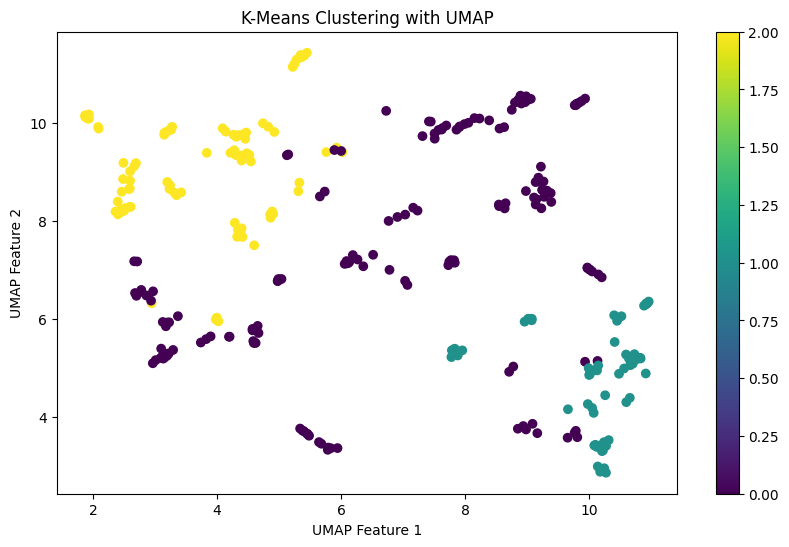

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


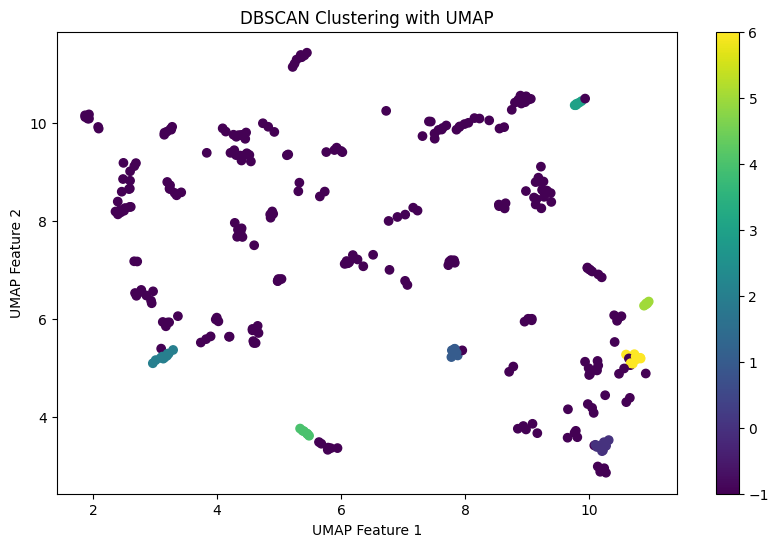

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


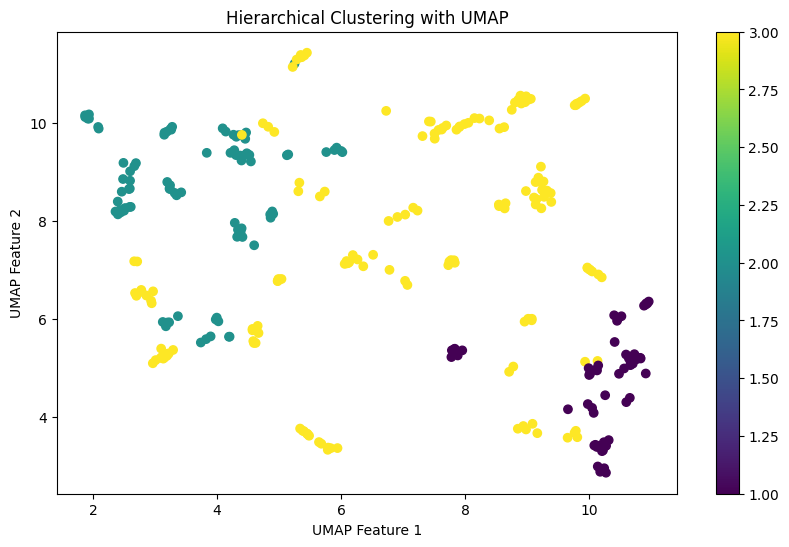

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


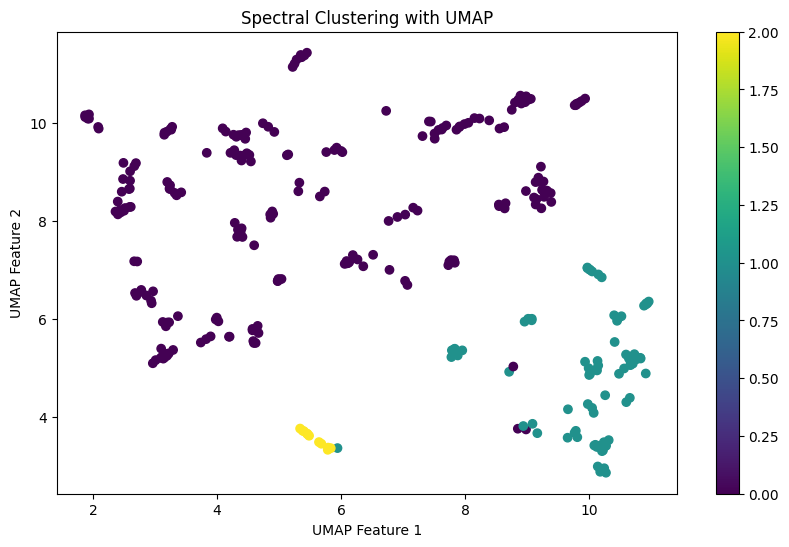

In [65]:
import umap
import matplotlib.pyplot as plt

def plot_clusters_with_umap(matrix, clusters, title):
    umap_reducer = umap.UMAP(random_state=42)
    umap_result = umap_reducer.fit_transform(matrix)
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], c=clusters, cmap='viridis')
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('UMAP Feature 1')
    plt.ylabel('UMAP Feature 2')
    plt.show()

# Usage example
plot_clusters_with_umap(matrix, kmeans_clusters, 'K-Means Clustering with UMAP')
plot_clusters_with_umap(matrix, clusters, 'DBSCAN Clustering with UMAP')  # Assuming 'clusters' from DBSCAN
plot_clusters_with_umap(matrix, cluster_labels, 'Hierarchical Clustering with UMAP')  # Assuming 'cluster_labels' from Ward


plot_clusters_with_umap(matrix, spectral_clusters, 'Spectral Clustering with UMAP')


In [66]:
# Evaluate DBSCAN
db_silhouette, db_davies = compute_clustering_metrics(matrix, clusters)
# Evaluate Hierarchical
ward_silhouette, ward_davies = compute_clustering_metrics(matrix, cluster_labels)
# Evaluate K-Means
kmeans_silhouette, kmeans_davies = compute_clustering_metrics(matrix, kmeans_clusters)

# Print the metrics for comparison
print(f"DBSCAN Silhouette: {db_silhouette}, DBSCAN Davies-Bouldin: {db_davies}")
print(f"Ward Silhouette: {ward_silhouette}, Ward Davies-Bouldin: {ward_davies}")
print(f"K-Means Silhouette: {kmeans_silhouette}, K-Means Davies-Bouldin: {kmeans_davies}")

spectral_silhouette, spectral_davies = compute_clustering_metrics(matrix, spectral_clusters)
print(f"Spectral Clustering Silhouette Score: {spectral_silhouette}")
print(f"Spectral Clustering Davies-Bouldin Index: {spectral_davies}")



DBSCAN Silhouette: 0.01556198459550785, DBSCAN Davies-Bouldin: 1.4693943753608043
Ward Silhouette: 0.060551084649063724, Ward Davies-Bouldin: 3.784093108022406
K-Means Silhouette: 0.0674498153892725, K-Means Davies-Bouldin: 3.6057993696859385
Spectral Clustering Silhouette Score: 0.07232365298186648
Spectral Clustering Davies-Bouldin Index: 2.594213477595356


In [67]:
#Silhouette Score WARD
# FCLUSTER
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score

# Assuming the rest of your code has been executed up to the clustering
from scipy.cluster.hierarchy import fcluster

# Assuming 'Z' is your linkage matrix from hierarchical clustering
# and 'MAX_DISTANCE' is your threshold for clustering
cluster_labels = fcluster(Z, MAX_DISTANCE, criterion='distance')
df['cluster_label'] = cluster_labels

# Now calculate the silhouette score
# Ensure your embeddings are appropriately prepared as 'matrix'
silhouette_avg = silhouette_score(matrix, cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")

# Continue with any further steps you have


Silhouette Score: 0.060551084649063724


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

# Assuming matrix contains your embeddings

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust these parameters based on your data
clusters = dbscan.fit_predict(matrix)

# Filter out noise points for silhouette calculation (-1 labels represent noise in DBSCAN)
filtered_labels = clusters[clusters != -1]
filtered_matrix = matrix[clusters != -1]

# Count the unique cluster labels (excluding noise)
num_clusters = len(np.unique(filtered_labels))

if num_clusters > 1:  # Ensure there's more than one cluster to calculate the score
    silhouette_avg = silhouette_score(filtered_matrix, filtered_labels)
    print(f"Silhouette Score: {silhouette_avg}")
    print(f"Number of clusters (excluding noise): {num_clusters}")
else:
    print("Not enough clusters to calculate a meaningful silhouette score.")


In [ ]:
df

In [ ]:
# Davies-Bouldin Index

SHOWING IN A WORD CLOUD - CLUSTERS

In [ ]:
len(df)

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

def generate_wordclouds(df):
    unique_clusters = np.unique(df['cluster_label'])
    print("UNIQUE CLUSTERS: ", unique_clusters)
    for cluster_num in unique_clusters:

        cluster_data = df[df['cluster_label'] == cluster_num]

        tfidf_vectorizer = TfidfVectorizer(stop_words='english')
        tfidf_matrix = tfidf_vectorizer.fit_transform(cluster_data['cleaned_information'])
        terms = tfidf_vectorizer.get_feature_names_out()
        scores = tfidf_matrix.sum(axis=0).A1
        freqs = dict(zip(terms, scores))
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freqs)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f'Word Cloud for Cluster {cluster_num}')
        plt.show()


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def generate_cluster_labels(df):
    unique_clusters = np.unique(df['cluster_label'])
    labels = []
    print("CLUSTERS IN GENERATE CLUSTER FUNC ", unique_clusters)
    for cluster_num in unique_clusters:

        cluster_data = df[df['cluster_label'] == cluster_num]

        tfidf_vectorizer = TfidfVectorizer(stop_words='english')
        tfidf_matrix = tfidf_vectorizer.fit_transform(cluster_data['cleaned_information'])
        terms = np.array(tfidf_vectorizer.get_feature_names_out())[tfidf_matrix.sum(axis=0).argsort()[0, ::-1]].flat[:5]
        label = ', '.join(terms)
        labels.append(label)
        print(f"Cluster {cluster_num} label: {label}")
    return labels


In [ ]:
import openai

# Generate meaningful labels for each cluster using GPT-3.5 Turbo
def create_gpt3_labels(labels):
    cluster_labels = []
    for label in labels:

        #prompt = "Please generate a concise label for the following cluster of terms."
        prompt = f"Generate a very specific and descriptive maximum 3-words-label for a cluster of topics involving: {label}. Aim for precision and relevance in a technical context. it is all about a webapplication where users like teachers or scholars can see timetable, do enrolments, add and confirm absences and many more."

        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": prompt},
                {"role": "user", "content": label}
            ]
        )
        new_label = response['choices'][0]['message']['content'].strip()
        cluster_labels.append(new_label)
    return cluster_labels


In [ ]:
# Perform clustering

clusters, Z = perform_hierarchical_clustering(embeddings, MAX_DISTANCE)

df['cluster_label'] = clusters  # Assign cluster labels to DataFrame

# Visualize using UMAP

# Generate word clouds for each cluster
generate_wordclouds(df)


# Generate labels using TF-IDF
labels = generate_cluster_labels(df)


# Create meaningful labels using GPT-3.5 Turbo
cluster_labels_reworked = create_gpt3_labels(labels)


# Create and display final cluster information
cluster_data = pd.DataFrame({
    'ClusterNumber': range(1, len(cluster_labels_reworked) + 1),
    'ClusterLabel': cluster_labels_reworked,
    'OriginalLabels': labels
})

print(cluster_data)



In [ ]:
df.head()

CATEGORIZING NEW TICKETS TO ONE OF THE CLUSTERS WITHOUT THE NEED OF DOING THE WHOLE CLUSTERSTUFF ETC AGAIN

In [ ]:
def plot_umap(embeddings, cluster_labels, new_ticket_index):
    reducer = umap.UMAP()
    embedding_2d = reducer.fit_transform(embeddings)
    plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=cluster_labels, cmap='Spectral', alpha=0.6)
    plt.scatter(embedding_2d[new_ticket_index, 0], embedding_2d[new_ticket_index, 1], c='red', s=100, edgecolors='k')  # Highlight new ticket
    plt.title("UMAP Projection of Ticket Embeddings")
    plt.colorbar()
    plt.show()

In [ ]:
def check_new_ticket(embeddings, reworked_ticket_text, df, update_path, threshold=0.5):
    print("Starting check_new_ticket...")

    # get last embedding
    new_embedding = embeddings[-1]
    all_embeddings_exept_last = embeddings[:-1]

    # Check if the DataFrame is empty or the existing_embeddings are insufficient
    if df.empty or len(embeddings) <= 1:  # Ensure there's at least one existing ticket besides the new one
        print("No existing tickets to compare or DataFrame is empty.")
        new_label = 0  # Starting with a new cluster if no valid data exists
    else:
        # Exclude the new embedding which is presumably the last one added
        print(new_embedding)
        # Calculate distances to all existing embeddings
        distances = euclidean_distances([new_embedding], all_embeddings_exept_last)
        min_distance = distances.min()

        print("Distance: ", distances.min())
        # Decide on the cluster label based on distance
        if min_distance > threshold:
          print("NEUES CLUSTER")
          new_label = df['cluster_label'].max() + 1 if not df.empty else 0
          #new_label = 0
          print(f"Assigning new cluster label: {new_label}")
        else:
            print("BESTEHENDES CLUSTER")
            closest_index = distances.argmin()
            print("CLOSEST INDEX: ", closest_index)
            if closest_index < len(df):
                new_label = df.iloc[closest_index]['cluster_label']
                #new_label = 0
                print(f"Assigning existing cluster label: {new_label}")
            else:
                print(f"Error: Closest index {closest_index} out of bounds for DataFrame of length {len(df)}")
                return df, None  # Return None if there's an index error

    # Append the new ticket's data as a new row to the DataFrame

    df.loc[len(df)-1, 'cluster_label'] =  new_label

    new_ticket_index = df.index[-1]  # Get the index of the newly added ticket
    return df, new_ticket_index

In [ ]:
def get_openai_embeddings_addon(texts, initial_path, update_path):
    # Check and load initial embeddings or initialize an empty array

    new_embeddings = []
    for text in texts:
        response = openai.Embedding.create(input=text, engine="text-embedding-ada-002")
        new_embeddings.append(response['data'][0]['embedding'])

    return new_embeddings

## CREATE ANOTHER TICKET AND RECLUSTER IT

In [ ]:
import numpy as np
import openai
import os
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.metrics.pairwise import euclidean_distances
from scipy.cluster.hierarchy import fcluster, linkage


initial_path = EMBEDDINGS_MID
update_path = EMBEDDINGS_MID_UPDATED
new_ticket = "eine gurke kommt plötzlich aus meinem handy anstelle einer banane."

reworked_ticket_text = rework_ticket_description_with_gptturbo(new_ticket)
print(f"Length of existing_embeddings: {len(embeddings)}")
print(f"Number of rows in df: {len(df)}")
df.loc[len(df), ['issue_title', 'reworked_information', 'cleaned_information']] = ["MY TEST TITLE FOR NEW ISSUES", reworked_ticket_text, reworked_ticket_text]


new_embeddings = get_openai_embeddings_addon([reworked_ticket_text], initial_path, update_path)[-1]

# Combine new embeddings with existing ones
new_embeddings = np.array(new_embeddings)
embeddings = np.vstack([embeddings, new_embeddings]) if embeddings.size else new_embeddings

# Save updated embeddings
np.save(update_path, embeddings)
print(f"Length of existing_embeddings: {len(embeddings)}")
print(f"Number of rows in df: {len(df)}")

#embeddings = np.load(update_path)[:-2]
#embeddings = np.load(update_path)[:-1]
print(f"Length of existing_embeddings: {len(embeddings)}")


In [ ]:
print(f"Length of existing_embeddings: {len(embeddings)}")
print(f"Number of rows in df: {len(df)}")

In [ ]:
df


In [50]:
#df = df.drop(len(df)-1)
#embeddings = np.load(update_path)[:-1]

In [ ]:
#print(reworked_ticket_text)

In [ ]:

# Call the check_new_ticket function
df, new_ticket_index = check_new_ticket(embeddings, reworked_ticket_text, df, update_path)



In [ ]:
plot_umap(embeddings, df['cluster_label'], new_ticket_index)

In [ ]:
 # Perform clustering

#clusters, Z = perform_hierarchical_clustering(embeddings, MAX_DISTANCE)

#df['cluster_label'] = clusters  # Assign cluster labels to DataFrame

# Visualize using UMAP
#visualize_umap(embeddings, clusters)

# Generate word clouds for each cluster
generate_wordclouds(df)


# Generate labels using TF-IDF
labels = generate_cluster_labels(df)


# Create meaningful labels using GPT-3.5 Turbo
cluster_labels_reworked = create_gpt3_labels(labels)


# Create and display final cluster information
cluster_data = pd.DataFrame({
    'ClusterNumber': range(1, len(cluster_labels_reworked) + 1),
    'ClusterLabel': cluster_labels_reworked,
    'OriginalLabels': labels
})

print(cluster_data)



In [ ]:
# Display all rows where 'cluster_label' equals 5
filtered_df = df[df['cluster_label'] == 6]

print(filtered_df)

In [ ]:
import umap
import matplotlib.pyplot as plt

'''
def plot_umap_updated(embeddings, cluster_labels):
    # Initialize UMAP
    print("LABELS: ", cluster_labels)
    reducer = umap.UMAP(random_state=42)
    # Transform the embeddings to 2D for visualization
    embedding_2d = reducer.fit_transform(embeddings)

    # Create a scatter plot
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=cluster_labels, cmap='Spectral', s=50, alpha=0.6)
    plt.colorbar(scatter)
    plt.title('UMAP Projection of Clusters')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.show()

# Assuming 'embeddings' and 'cluster_labels' are defined
plot_umap_updated(embeddings, df['cluster_label'])

'''

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import umap

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import umap.umap_ as umap

# Example DataFrame 'cluster_data' which you should already have
# cluster_data = pd.DataFrame({
#     'ClusterNumber': [1, 2, 3, 4, 5],
#     'ClusterLabel': ['Tech Support', 'Product Feedback', 'Complaints', 'Inquiries', 'Other'],
#     'OriginalLabels': ['support', 'feedback', 'complaint', 'inquiry', 'other']
# })

# Assuming cluster_data is predefined as above
label_map = cluster_data.set_index('ClusterNumber')['ClusterLabel'].to_dict()

# Define a list of colors (or use a matplotlib colormap)
colors = plt.cm.Spectral(np.linspace(0, 1, len(cluster_data)))
color_map = dict(zip(cluster_data['ClusterNumber'], colors))

def plot_umap_updated(embeddings, cluster_ids):
    # Initialize UMAP
    reducer = umap.UMAP(random_state=42)
    embedding_2d = reducer.fit_transform(embeddings)

    plt.figure(figsize=(10, 7))

    # Iterate over each unique cluster id found in the dataset
    for cluster_id in np.unique(cluster_ids):
        # Find points that belong to the current cluster
        idx = np.where(cluster_ids == cluster_id)
        # Use label and color mappings, default to 'grey' if not found
        cluster_label = label_map.get(cluster_id, 'Unknown')
        cluster_color = color_map.get(cluster_id, 'grey')

        # Plot each cluster using assigned colors and add label for the legend
        plt.scatter(embedding_2d[idx, 0], embedding_2d[idx, 1], color=cluster_color, label=cluster_label, s=50, alpha=0.6)

    plt.legend(title='Cluster Labels')
    plt.title('UMAP Projection of Clusters with Custom Labels')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.show()

# Assuming 'embeddings' and 'cluster_ids' are defined appropriately
plot_umap_updated(embeddings, df['cluster_label'])


In [ ]:
import plotly.express as px
import umap.umap_ as umap

def plot_umap_interactive(embeddings, cluster_ids, titles):
    # Initialize UMAP
    reducer = umap.UMAP(random_state=42)
    embedding_2d = reducer.fit_transform(embeddings)

    # Create a DataFrame for the Plotly scatter plot
    df_plot = pd.DataFrame({
        'UMAP Dimension 1': embedding_2d[:, 0],
        'UMAP Dimension 2': embedding_2d[:, 1],
        'Cluster': [label_map[cid] for cid in cluster_ids],
        'Title': titles
    })

    # Create a scatter plot
    fig = px.scatter(df_plot, x='UMAP Dimension 1', y='UMAP Dimension 2',
                     color='Cluster', labels={'color': 'Cluster Label'},
                     hover_data=['Title'],
                     title='UMAP Projection of Clusters')
    fig.update_traces(marker=dict(size=12, line=dict(width=2, color='DarkSlateGrey')), selector=dict(mode='markers'))
    fig.show()

# Example usage
plot_umap_interactive(embeddings, df['cluster_label'], df['issue_title'])


In [ ]:
df

**3. Adaptability and accuracy of the system**
Goal: Without manual intervention, the system should not only correctly categorize new tickets with
new content, but also adapt the ticket categories accordingly.
Deliverable: A real-time classification engine that adapts to new data in real time. This module is
further developed through transfer learning.

In [ ]:
from sklearn.manifold import TSNE

def plot_tsne(embeddings, cluster_labels):
    # Initialize t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    # Transform the embeddings to 2D
    embedding_2d = tsne.fit_transform(embeddings)

    # Plotting
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=cluster_labels, cmap='Spectral', s=50, alpha=0.6)
    plt.colorbar(scatter)
    plt.title('t-SNE Projection of Clusters')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

plot_tsne(embeddings, df['cluster_label'])
